In [1]:
import os
import random
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from joblib import dump, load
from tqdm import tqdm
from wandb.sklearn import plot_learning_curve
from sklearn.model_selection import GridSearchCV
import time

MODEL_OUTPUT_PATH = "../src/models/"
SCALER_OUTPUT_PATH = "../src/scaler/"

# Distributed Denial-of-Service Risk Prediction

# Data Generation

In [3]:
columns = ['Industry', 'Region', 'Invested Amount', 'Successful Attacks', 'Failed Attacks', 'Business Value', 'Known Vulnerabilities', 'External Advisor', 'Risk']
features = columns[:-1]
INDUSTRIES = ['AUTOMOTIVE', 'HEALTHCARE', 'ECOMMERCE', 'TELECOM', 'FINANCIAL SERVICES', 'EDUCATION', 'OTHER']
REGIONS = ['EUROPE', 'NORTH AMERICA', 'SOUTH AMERICA', 'AFRICA', 'ASIA']
INDUSTRY_TO_RISK = {
    'AUTOMOTIVE': 0.2,
    'HEALTHCARE': 0.8,
    'ECOMMERCE': 0.6,
    'TELECOM': 0.75,
    'FINANCIAL SERVICES': 1,
    'EDUCATION': 0.3,
    'OTHER': 0.5
}

REGION_TO_RISK = {
    'EUROPE': 0.8,
    'NORTH AMERICA': 1,
    'SOUTH AMERICA': 1,
    'AFRICA': 0.2,
    'ASIA': 0.5
}

ADVISOR = ['YES', 'NO']
LEVELS = ['LOW', 'MEDIUM', 'HIGH']

In [19]:
def generate_data(nr_entries = 1000, min_nr_attacks = 0, nr_attacks = 50, 
                  avg_business_value = 5000000, std_business_value = 50000, max_invested_perc = 0.3, max_nr_vulnerabilities = 10):
    df = pd.DataFrame(columns=columns)
    for i in tqdm(range(0, nr_entries)):
        
        region = random.choice(REGIONS)
        industry = random.choice(INDUSTRIES)
        failed_attack = random.randrange(nr_attacks)
        succ_attack = random.randrange(nr_attacks)
        
        business_value = int(numpy.random.normal(loc=avg_business_value, scale=std_business_value))
        invested_perc = random.uniform(0, max_invested_perc)
        invested_amount = int(invested_perc * business_value)
        
        known_vulnerabilities = random.randrange(max_nr_vulnerabilities)
        external_adv = random.choice(ADVISOR)

        # Risk is computed based on the other parameters and is then categorized using 'get_categorized_risk'
        computed_risk = (succ_attack / nr_attacks) + (known_vulnerabilities / max_nr_vulnerabilities) + INDUSTRY_TO_RISK[industry] + REGION_TO_RISK[region] - (invested_perc / max_invested_perc) - ADVISOR.index(external_adv)
        df.loc[i] = [industry, region, invested_amount, succ_attack, failed_attack, business_value, known_vulnerabilities, external_adv, get_categorized_risk(computed_risk)]
    return df

def get_categorized_risk(weighted_risk, low_medium_boundary = 1.0, medium_high_boundary = 2.0):
  if weighted_risk >= medium_high_boundary:
      return "HIGH"
  elif weighted_risk >= low_medium_boundary and weighted_risk < medium_high_boundary:
      return "MEDIUM"
  else:
      return "LOW"

In [20]:
data = generate_data(nr_entries = 100000)
#data = pd.read_csv('./ddos_data.csv')
#data.pop('Unnamed: 0')

100%|██████████| 100000/100000 [11:56<00:00, 139.56it/s]


In [23]:
data.head()

,Industry,Region,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Known Vulnerabilities,External Advisor,Risk
0,OTHER,EUROPE,352962,36,11,4981229,5,NO,MEDIUM
1,ECOMMERCE,NORTH AMERICA,644025,17,39,4974608,6,NO,MEDIUM
2,EDUCATION,NORTH AMERICA,195600,11,36,4935406,1,YES,MEDIUM
3,FINANCIAL SERVICES,ASIA,888788,28,18,5040050,6,YES,HIGH
4,OTHER,SOUTH AMERICA,1371310,40,33,4987948,0,NO,LOW


In [25]:
data.describe()

100000

### Data Export as .csv

In [26]:
data.to_csv('ddos_data.csv')

## Data Processing

### Categorization Step

In [27]:
start = time.time()

levels_mapping = { 'LOW': 0, 'MEDIUM': 1, 'HIGH': 2 }
advisor_mapping = { 'NO': 0, 'YES': 1 }
industry_mapping = {
    'AUTOMOTIVE': 0,
    'HEALTHCARE': 1,
    'ECOMMERCE': 2,
    'TELECOM': 3,
    'FINANCIAL SERVICES': 4,
    'EDUCATION': 5,
    'OTHER': 6
}

region_mapping = {
    'EUROPE': 0,
    'NORTH AMERICA': 1,
    'SOUTH AMERICA': 2,
    'AFRICA': 3,
    'ASIA': 4
}

data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping, 'Industry': industry_mapping, 'Region': region_mapping})

stop = time.time()
print(f"Categorization time: {stop - start}s")

Categorization time: 0.16359829902648926s


In [28]:
data.head()

,Industry,Region,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Known Vulnerabilities,External Advisor,Risk
0,6,0,352962,36,11,4981229,5,0,1
1,2,1,644025,17,39,4974608,6,0,1
2,5,1,195600,11,36,4935406,1,1,1
3,4,4,888788,28,18,5040050,6,1,2
4,6,2,1371310,40,33,4987948,0,0,0


### Normalization Step - using scaler

In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Used for the scikit models
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, test_size=0.2)

scaler = MinMaxScaler()
scaler.fit(X_train)

# Normalized Data
X = data[features]
Y = data["Risk"]
X_normalized = scaler.transform(data[features])


# Normalized Splitted Data
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [30]:
dump(scaler, SCALER_OUTPUT_PATH + 'MinMaxScaler_ddos.joblib') 

['../src/scaler/MinMaxScaler_ddos.joblib']

In [31]:
scaler.scale_

array([1.66666667e-01, 2.50000000e-01, 6.51706526e-07, 2.04081633e-02,
       2.04081633e-02, 2.20272565e-06, 1.11111111e-01, 1.00000000e+00])

# Multilayer Perceptron (MLP) using Backpropagation

In [32]:
from sklearn.neural_network import MLPClassifier

In [33]:
mlp = MLPClassifier()

In [34]:
mlp_params={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(5, 5)],
'solver': ["lbfgs", "sgd", "adam"],
'activation': ["logistic", "relu", "tanh"]
}

# Instanciate the Grid for parameter tuning
mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='accuracy', n_jobs=-1)

mlp = mlp_grid.fit(X_train_normalized, y_train)

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
print(mlp.best_estimator_)
print(mlp.best_params_)
print('Best Accuracy: {0:.2%}'.format(mlp.best_score_))

MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5),
              learning_rate='invscaling')
{'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'learning_rate': 'invscaling', 'solver': 'adam'}
Best Accuracy: 89.21%


## Prediction

In [36]:
prediction_result_mapping = {0: 'LOW', 1: 'MEDIUM', 2: 'HIGH'}

predicted_risk = mlp.predict(scaler.transform([[4, 0, 57879, 1, 6, 4947796, 0, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW


## Evaluate

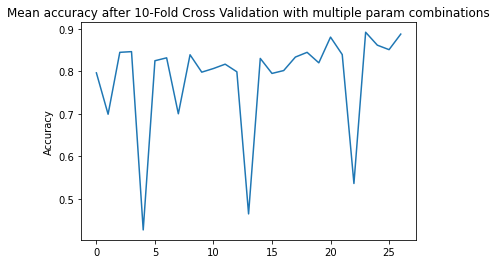

In [37]:
test_scores = mlp.cv_results_['mean_test_score']

plt.title("Mean accuracy after 10-Fold Cross Validation with multiple param combinations")
plt.plot(test_scores)
plt.ylabel("Accuracy")
plt.show()

In [38]:
accuracy = mlp.score(X_test_normalized, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 90.59%


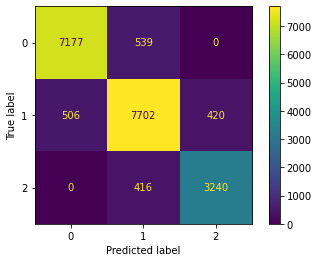

In [39]:
plot_confusion_matrix(mlp, X_test_normalized, y_test)  
plt.show()

## Export

In [ ]:
dump(mlp, MODEL_OUTPUT_PATH + 'MLP_ddos_classifier.joblib') 